## Loading required dataframes

In [6]:
from splitters import k_fold_edge_split, train_test_split_edges
from dataset_loader import load_dataframes
from model import Net
from utils import train_model, device_finder, train_model_on_folds, predict_edges, plot_layers_curve
import warnings
from graph_data_creater import create_graph_data_with_different_features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import LocalDegreeProfile
import torch
from torch_geometric.data import Data
import numpy as np
# plotting shapes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()
data_dt, data_w2v, data_n2v, data_fin, data_in, data_se = create_graph_data_with_different_features()

## Loading required Graph data class

In [7]:
all_edges = []

print(all_df.shape)

for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

print(len(all_edges))

(2716, 2)
3732


In [4]:
# loading all edges of undirected graph

x_nv = final_nv_df.iloc[:, :128]
x_nv = np.array(x_nv, dtype=np.float32)

nodes_nv_list = list()
nodes_nv_dict = dict()

count = 0
for x in final_nv_df.values[:, 128:129]:
    nodes_nv_dict[str(x.squeeze())] = count
    count+=1
    nodes_nv_list.append(str(x.squeeze()))

edges_nv = list()
for edge in all_edges:
    if edge[0] in nodes_nv_list and edge[1] in nodes_nv_list:
        edges_nv.append([nodes_nv_dict[edge[0]], nodes_nv_dict[edge[1]]])
nodes_nv = list(nodes_nv_dict.values())

nodes_nv = torch.from_numpy(np.array(nodes_nv))
edges_nv = torch.from_numpy(np.array(edges_nv))
x_nv = torch.from_numpy(np.array(x_nv))

data_nv = Data(x=x_nv, edge_index=edges_nv.T)

raw_data = Data(edge_index=edges_nv.T)
ldp = LocalDegreeProfile()
ldp(raw_data)
raw_data

/home/sina/anaconda3/envs/pyg/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Data(edge_index=[2, 3406], x=[752, 5])

## Comparing models with different graph layers (GCNConv, SAGEConv, GATConv)

In [ ]:
folds = k_fold_edge_split(data_nv, only_upper_triangular_portion=False)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []

for index in range(0, 6):
    train_loss, val_acc, test_acc, model, val_aupr, test_aupr, val_fscore, test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
    t_list.append(train_loss)
    v_list.append(val_acc)
    te_list.append(test_acc)

for i in range(len(t_list)):
    loss_ave = np.average(t_list[i])
    val_acc_ave = np.average(v_list[i])
    test_acc_ave = np.average(te_list[i])

models = ['2 layers GCN, 2 layers SAGE, 3 layers SAGE, 2 layers GAT, SAGE-GCN-SAGE, 3 layers GAT']

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
for i in range(len(t_list)):
    plt.plot(t_list[i], label=f'{models[i]}')
plt.legend()
plt.title('train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(v_list)):
    plt.plot(v_list[i], label=f'{models[i]}')
plt.legend()
plt.title('val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(te_list)):
    plt.plot(te_list[i], label=f'{models[i]}')
plt.legend()
plt.title('test acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

t_loss_ave = []
v_ave = []
t_ave = []

top = 100

for i in range(len(v_list)):
    t_loss_ave.append(np.average(t_list[i][:top]))
    v_ave.append(np.average(v_list[i][:top]))
    t_ave.append(np.average(te_list[i][:top]))

plot_layers_curve(models, t_loss_ave, v_ave, t_ave)

t_loss_last = []
v_last = []
te_last = []
last = 100
for i in range(len(v_list)):
    t_loss_last.append(t_list[i][last])
    v_last.append(v_list[i][last])
    te_last.append(te_list[i][last])

plot_layers_curve(models, t_loss_last, v_last, te_last)
#########################################################################
plt.figure(figsize=(8, 6))

values = [te_list[0][last], te_list[1][last], te_list[2][last], te_list[3][last], te_list[4][last], te_list[5][last]]

d = {'types': models, 'values': values}
df = pd.DataFrame(d, columns=['types', 'values'])
plots = sns.barplot(x='types', y='values', data=df)
plt.title('Val AUC Score')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.4f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center', 
    size=15, xytext=(0, 5),
    textcoords='offset points')

## Comparing GCN model with different number of layers

Epoch: 100, Train Loss: 0.409322, Val Auc: 0.982131, Test Auc: 0.983735


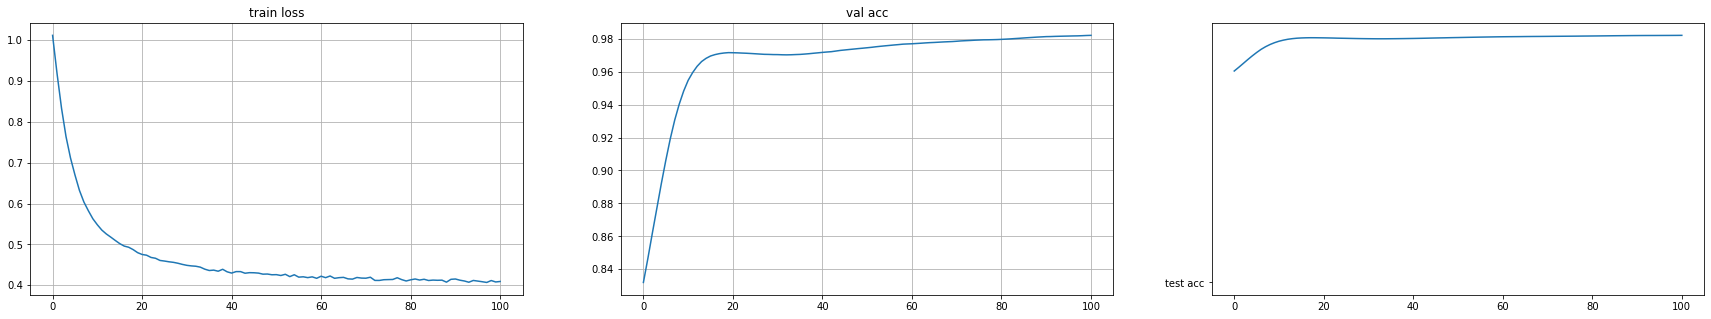

Epoch: 100, Train Loss: 0.406711, Val Auc: 0.980907, Test Auc: 0.982690


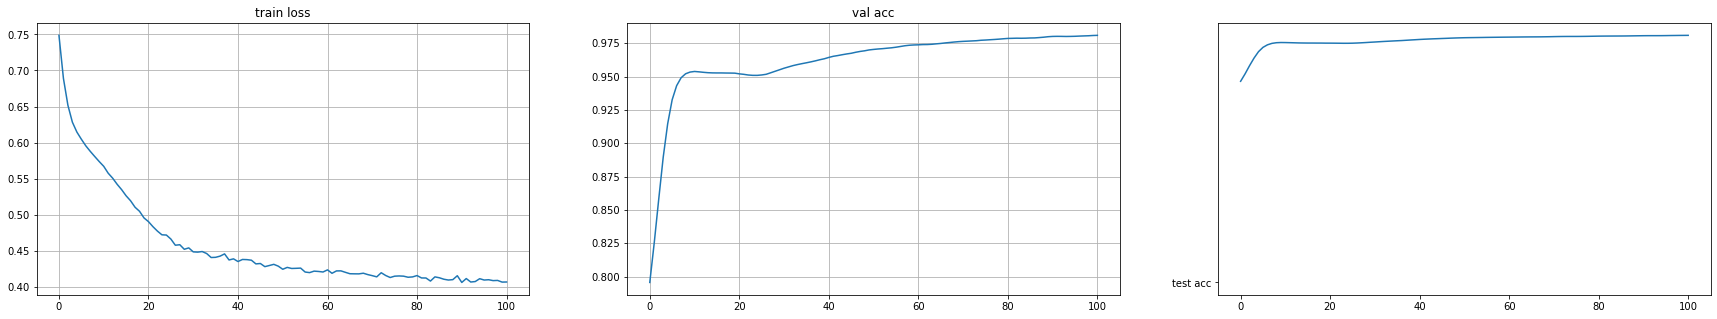

Epoch: 100, Train Loss: 0.413151, Val Auc: 0.976877, Test Auc: 0.978453


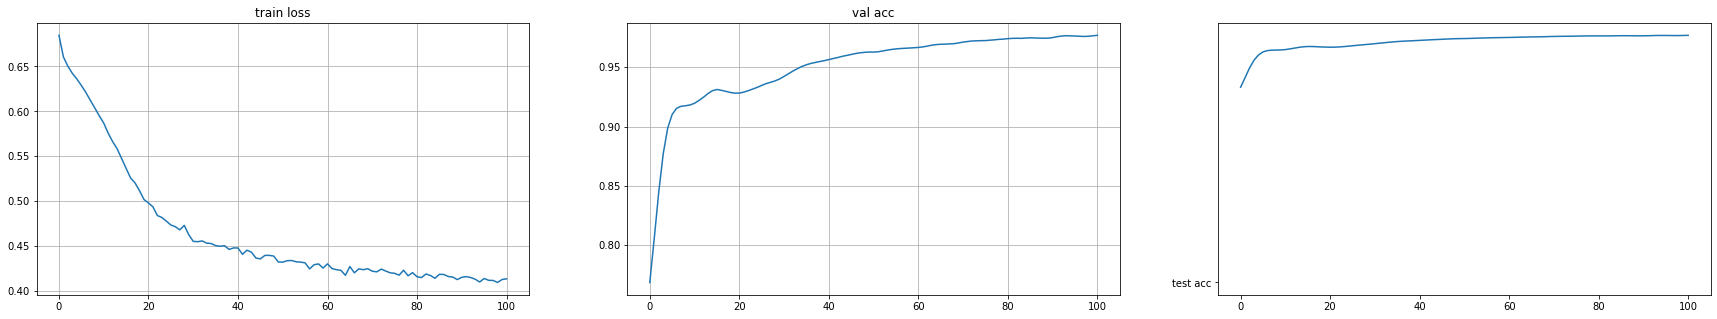

Epoch: 100, Train Loss: 0.413155, Val Auc: 0.973882, Test Auc: 0.977057


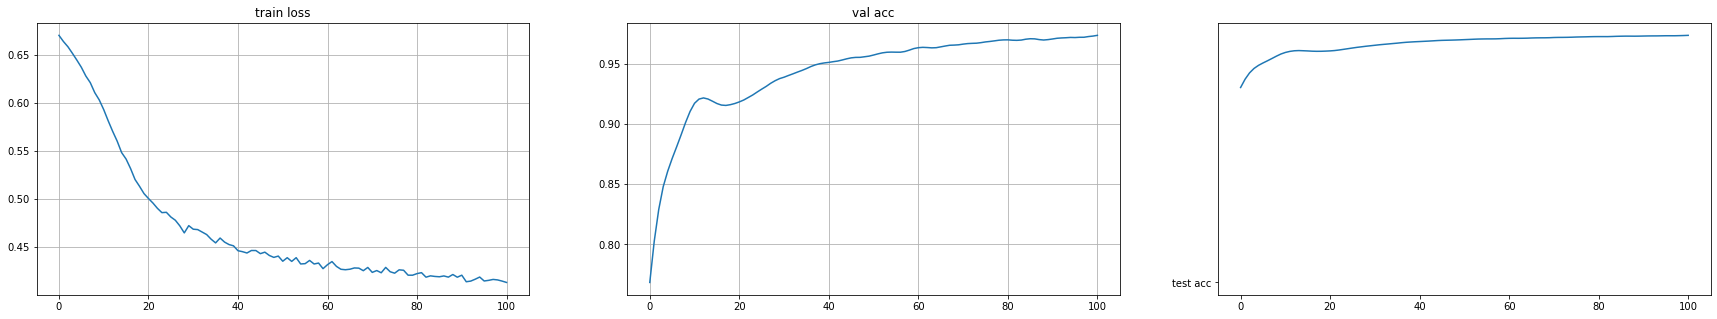

Epoch: 100, Train Loss: 0.419862, Val Auc: 0.968628, Test Auc: 0.971173


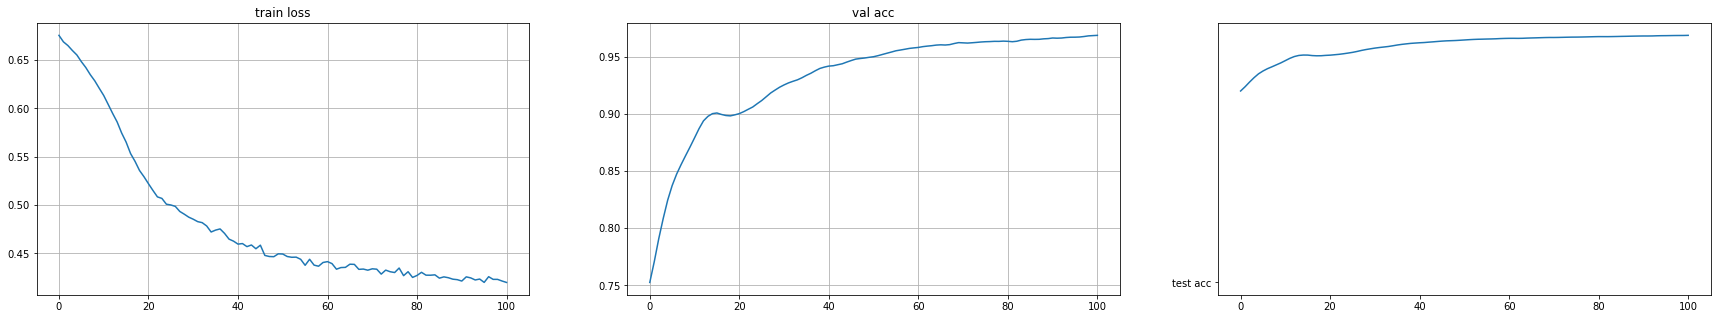

Epoch: 100, Train Loss: 0.514876, Val Auc: 0.874064, Test Auc: 0.866763


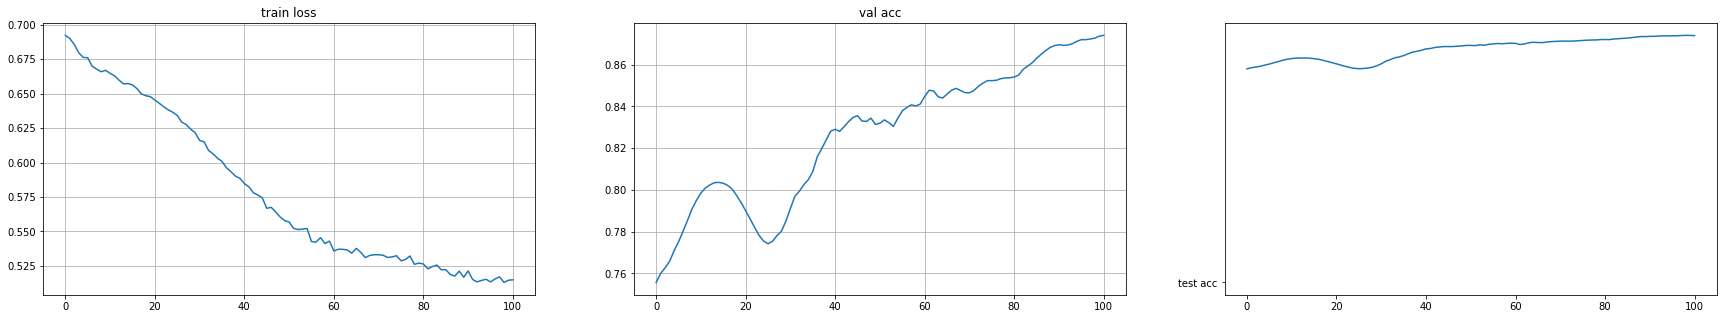

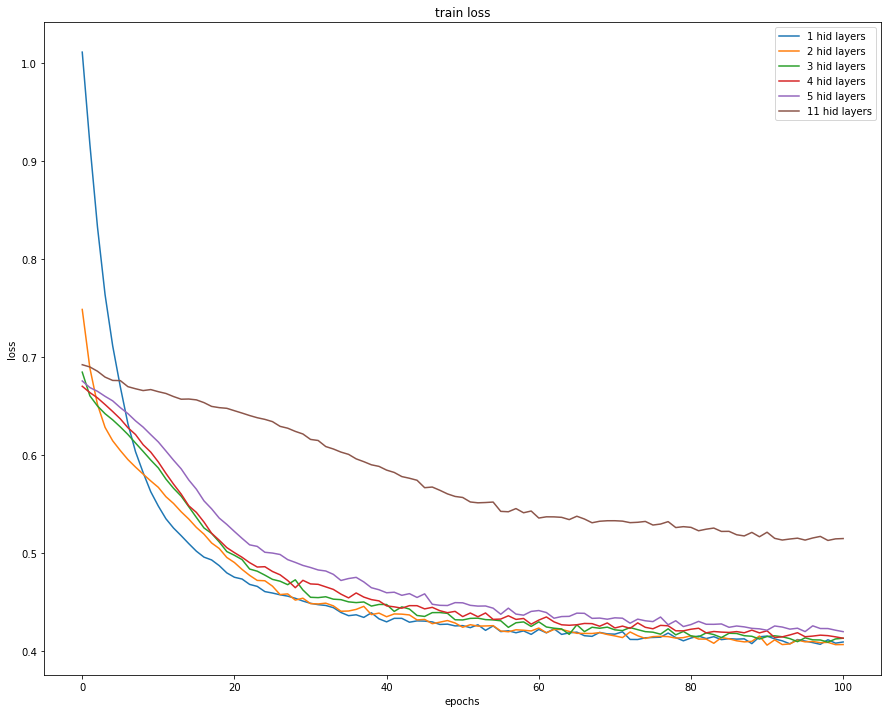

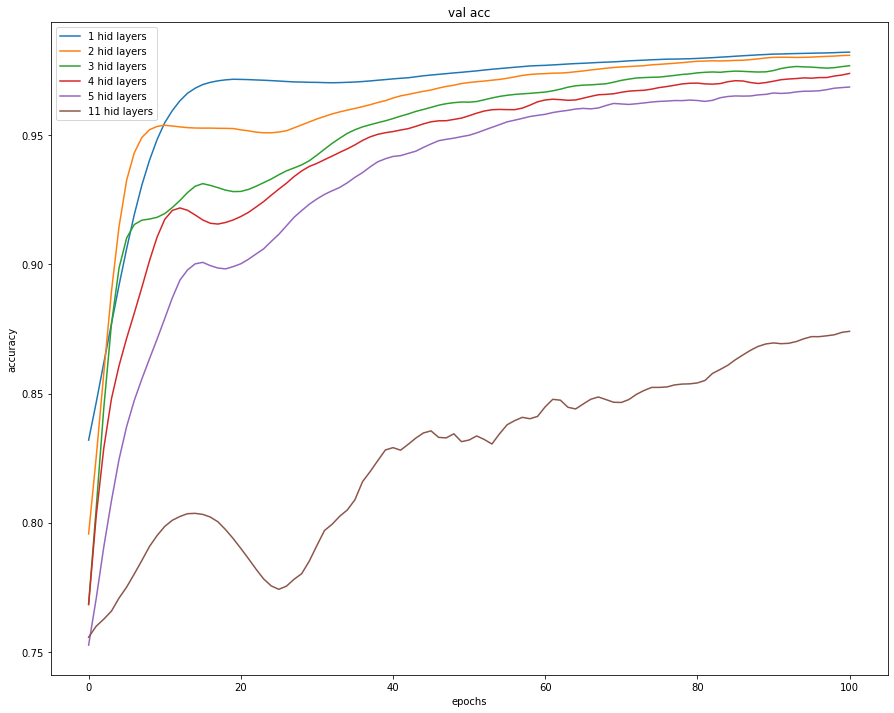

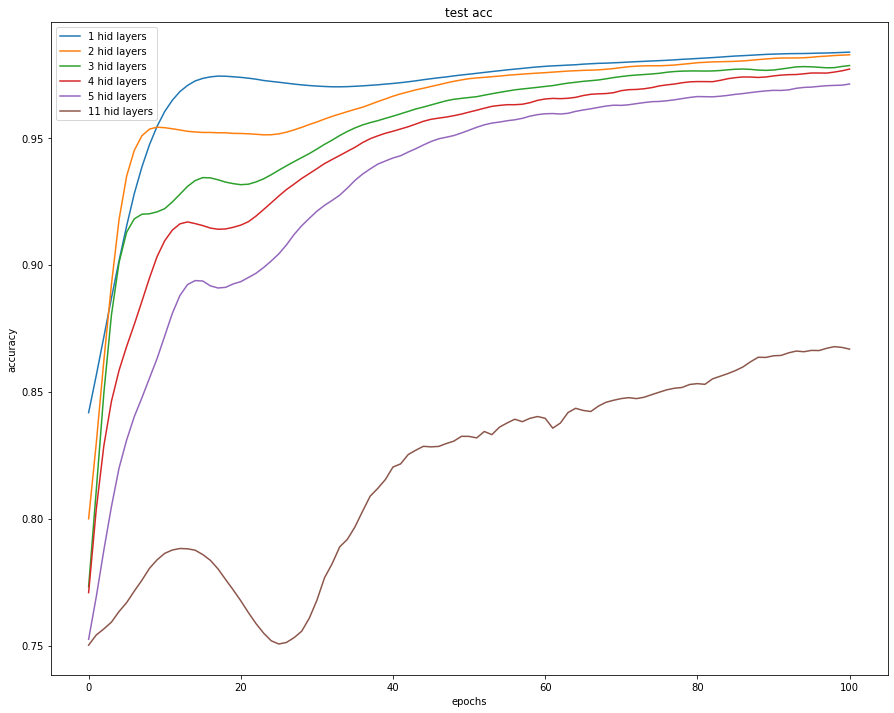

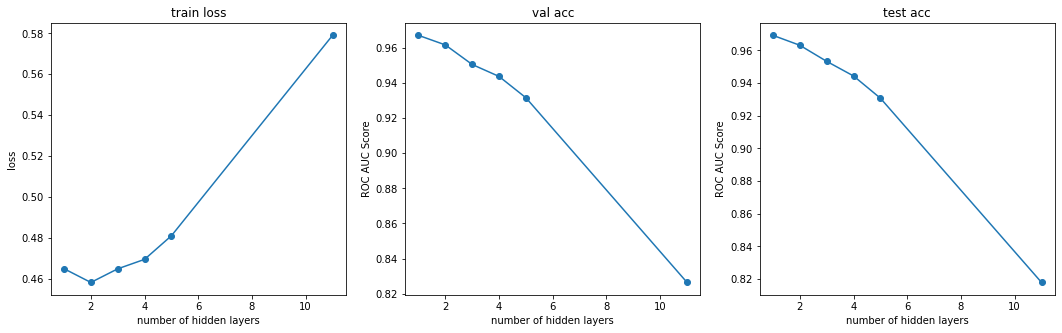

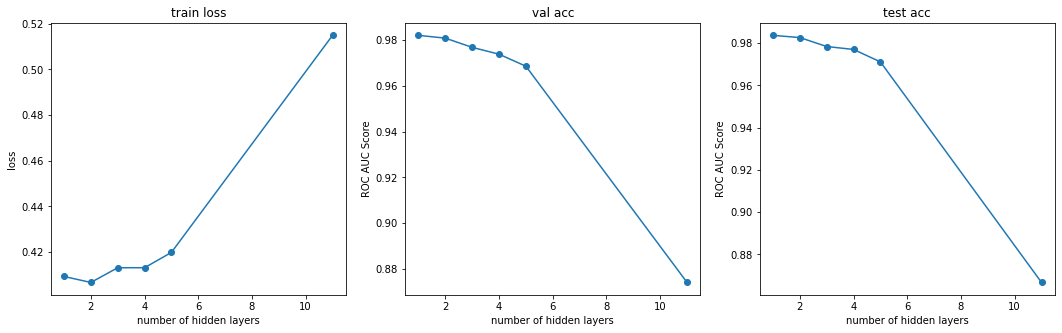

In [5]:
folds = k_fold_edge_split(data_nv, only_upper_triangular_portion=False)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []

for index in range(7, 13):
    train_loss, val_acc, test_acc, model, val_aupr, test_aupr, val_fscore, test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
    t_list.append(train_loss)
    v_list.append(val_acc)
    te_list.append(test_acc)

for i in range(len(t_list)):
    loss_ave = np.average(t_list[i])
    val_acc_ave = np.average(v_list[i])
    test_acc_ave = np.average(te_list[i])

model_layers = [1, 2, 3, 4, 5, 11]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
for i in range(len(t_list)):
    plt.plot(t_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(v_list)):
    plt.plot(v_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(te_list)):
    plt.plot(te_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('test acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

t_loss_ave = []
v_ave = []
t_ave = []

top = 100

for i in range(len(v_list)):
    t_loss_ave.append(np.average(t_list[i][:top]))
    v_ave.append(np.average(v_list[i][:top]))
    t_ave.append(np.average(te_list[i][:top]))

plot_layers_curve(model_layers, t_loss_ave, v_ave, t_ave)

t_loss_last = []
v_last = []
te_last = []
last = 100
for i in range(len(v_list)):
    t_loss_last.append(t_list[i][last])
    v_last.append(v_list[i][last])
    te_last.append(te_list[i][last])

plot_layers_curve(model_layers, t_loss_last, v_last, te_last)
#################################################################
plt.figure(figsize=(8, 6))

models = ['2 layers', '3 layers', '4 layers', '5 layers', '6 layers', '12 layers']
values = [te_list[0][last], te_list[1][last], te_list[2][last], te_list[3][last], te_list[4][last], te_list[5][last]]

d = {'types': models, 'values': values}
df = pd.DataFrame(d, columns=['types', 'values'])
plots = sns.barplot(x='types', y='values', data=df)
plt.title('Val AUC Score')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.4f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center', 
    size=15, xytext=(0, 5),
    textcoords='offset points')

## comparing raw_data, data with node2vec, data with pca on node2vec

Epoch: 100, Train Loss: 0.531671, Val Auc: 0.854894, Test Auc: 0.850690


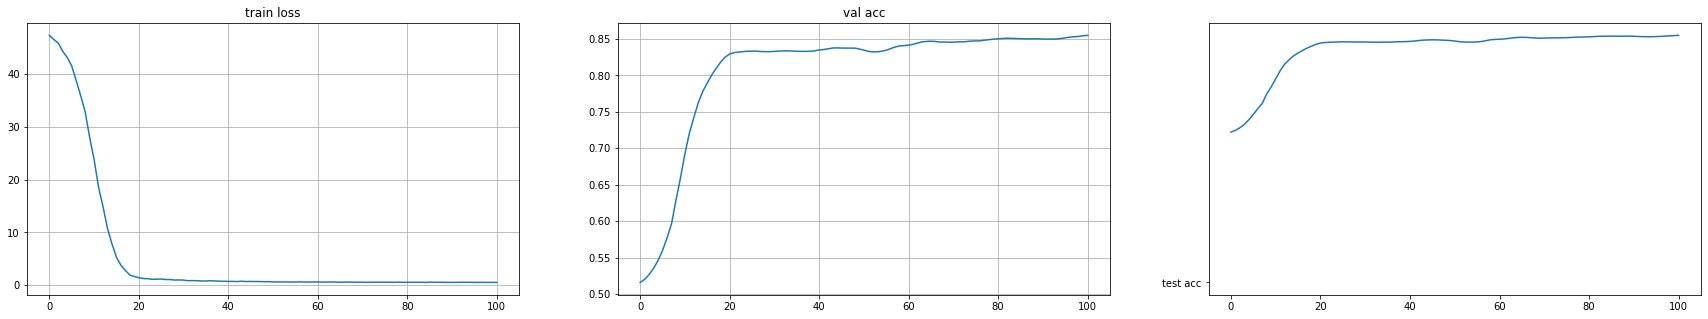

Epoch: 100, Train Loss: 0.418905, Val Auc: 0.977799, Test Auc: 0.974258


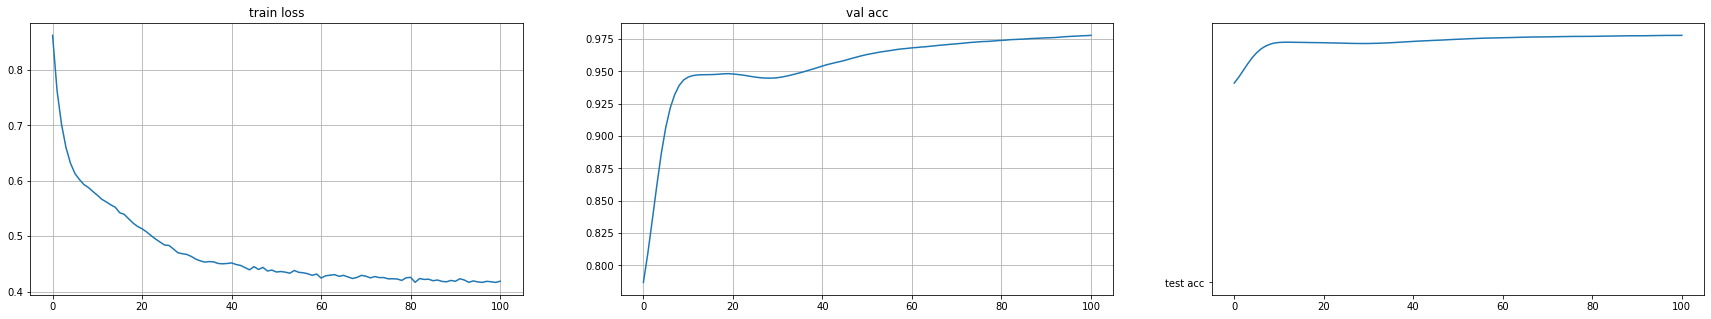

Epoch: 100, Train Loss: 0.426378, Val Auc: 0.982927, Test Auc: 0.978225


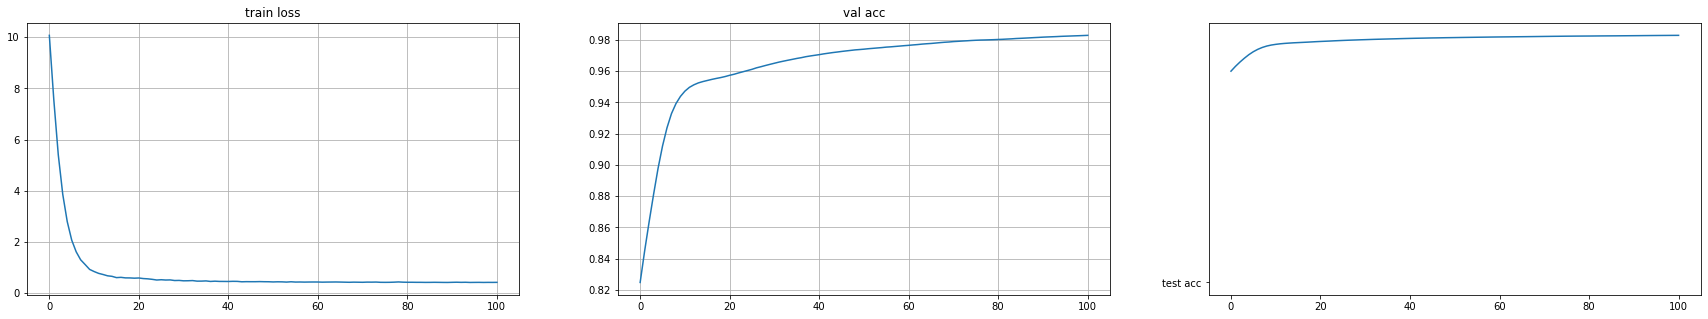

In [23]:
index = 8
folds = k_fold_edge_split(raw_data, only_upper_triangular_portion=False)
device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64
raw_train_loss, raw_val_auc, raw_test_auc, model, raw_val_aupr, raw_test_aupr, raw_val_fscore, raw_test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                                                                out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
########################################################################
folds = k_fold_edge_split(data_nv, only_upper_triangular_portion=False)
in_channels = folds[0].num_features
nv_train_loss, nv_val_auc, nv_test_auc, model, nv_val_aupr, nv_test_aupr, nv_val_fscore, nv_test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                                                                out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
########################################################################
# Scale data before applying PCA
scaling=StandardScaler()
df1 = data_nv.x
# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
# Set the n_components=3
principal=PCA(n_components=32)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
# Check the dimensions of data after PCA

x = torch.from_numpy(x)
x = x.float()
data = Data(x=x, edge_index=edges_nv.T)
folds = k_fold_edge_split(data, only_upper_triangular_portion=False)

device = device_finder()
in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

pca_nv_train_loss, pca_nv_val_auc, pca_nv_test_auc, model, pca_nv_val_aupr, pca_nv_test_aupr, pca_nv_val_fscore, pca_nv_test_fscore = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels,
                                                                                hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)

In [27]:
data_types = ['Raw-Data', 'Data-N2V', 'Data-PCA-N2V']
last = 99
data_loss_result = [raw_train_loss[last], nv_train_loss[last], pca_nv_train_loss[last]]
data_val_auc_result = [raw_val_auc[last], nv_val_auc[last], pca_nv_val_auc[last]]
data_test_auc_result = [raw_test_auc[last], nv_test_auc[last], pca_nv_test_auc[last]]
data_val_aupr_result = [raw_val_aupr[last], nv_val_aupr[last], pca_nv_val_aupr[last]]
data_test_aupr_result = [raw_test_aupr[last], nv_test_aupr[last], pca_nv_test_aupr[last]]
data_val_fscore_result = [raw_val_fscore[last], nv_val_fscore[last], pca_nv_val_fscore[last]]
data_test_fscore_result = [raw_test_fscore[last], nv_test_fscore[last], pca_nv_test_fscore[last]]

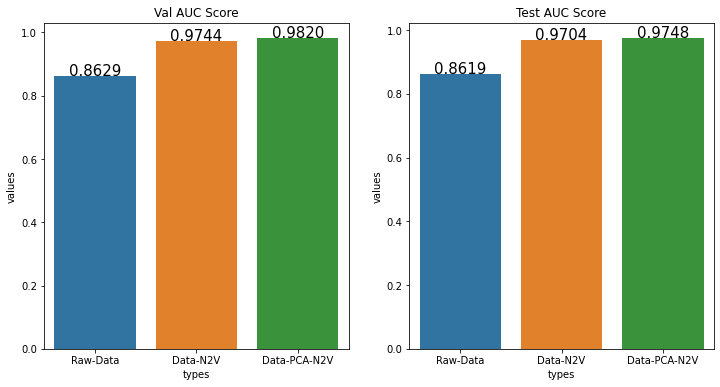

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(121)
d = {'types': data_types, 'values': data_val_aupr_result}
df = pd.DataFrame(d, columns=['types', 'values'])
plots = sns.barplot(x='types', y='values', data=df)
plt.title('Val AUC Score')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.4f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center', 
    size=15, xytext=(0, 5),
    textcoords='offset points')
plt.ylim(0.8, 1.0)
plt.subplot(122)
d = {'types': data_types, 'values': data_test_aupr_result}
df = pd.DataFrame(d, columns=['types', 'values'])
plots = sns.barplot(x='types', y='values', data=df)
plt.title('Test AUC Score')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.4f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center', 
    size=15, xytext=(0, 5),
    textcoords='offset points')

plt.ylim(0.8, 1.0)
plt.show()